In [ ]:
#### CS CM124 Challenge 2 Code #### 
# Author: Devon Shao 
# Date: 12/15/23

# Notes: 
# - Train many different types of models to see which predicts the phenotype the best 
# - Each code chunk corresponds to a different model
# - Code lines: pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None) and os.system("zip -r predictions.zip predictions.csv") are 

In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.mixture import GaussianMixture
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pomegranate import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn import linear_model

In [2]:
geno_train= np.array(pd.read_csv("C:/Users/dshao/Downloads/Challenge2/Challenge2/train.genotype.txt", sep=' ', dtype=float, header=None))
pheno_train = np.array(pd.read_csv("C:/Users/dshao/Downloads/Challenge2/Challenge2/train.phenotype.txt", sep=' ', dtype=float, header=None))
geno_test = np.array(pd.read_csv("C:/Users/dshao/Downloads/Challenge2/Challenge2/test.genotype.txt", sep=' ', dtype=float, header=None))

(2000, 200)
2


[0.01008121 0.00948675 0.009202   0.00917277]


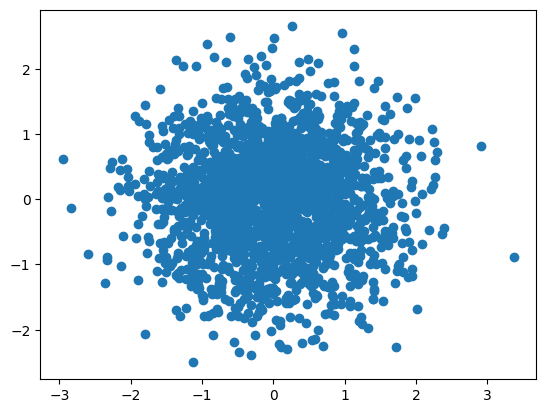

In [5]:
#### PCA ### 

# Run PCA on dataset 
pca = PCA(n_components=4)
pca.fit(geno_train)
geno_train_pca = pca.transform(geno_train)
print(pca.explained_variance_ratio_)

# Plot  PCs 1 & 2 
plt.scatter(geno_train_pca[:,0], geno_train_pca[:,1])

[2 0 1 ... 3 3 1]
(5, 200)


Text(0, 0.5, 'PC2')

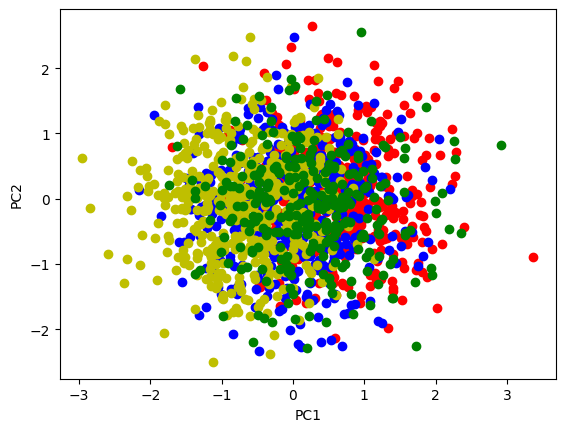

In [8]:
#### Using kmeans to predict groups and coloring PCA based on groups ####

#Run kmeans clustering on the dataset with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=5)
labels = kmeans.fit_predict(geno_train)
print(labels)
print(kmeans.cluster_centers_.shape)

# Color the points in the PCA based on what cluster they were predicted to belong to
Cluster1 = geno_train_pca[labels==0]
Cluster2 = geno_train_pca[labels==1]
Cluster3 = geno_train_pca[labels==2]
Cluster4 = geno_train_pca[labels==3]

plt.scatter(Cluster2[:,0],Cluster2[:,1], c='r')
plt.scatter(Cluster3[:,0],Cluster3[:,1], c='b')
plt.scatter(Cluster4[:,0],Cluster4[:,1], c='y')
plt.scatter(Cluster1[:,0],Cluster1[:,1], c='g')
#plt.scatter(Cluster)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [4]:
## GMM ## 

# Build and fit the gaussian mixture model
gm = GaussianMixture(n_components=200)
gm = gm.fit(geno_train)

# Create prediction based on test data
gm.predict(geno_test)

array([ 97, 149,  54, ...,  98,  97,  81], dtype=int64)

In [9]:
## Lasso ## 

# Build and fit a lasso model
model = linear_model.Lasso(alpha=0.1)
model.fit(geno_train, pheno_train)

# Predict phenotype based on genotype test data
pheno_pred = np.array(model.predict(geno_test), dtype=float)
pheno_pred

#pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None)
#os.system("zip -r predictions.zip predictions.csv")

array([-0.41923918, -0.41923918, -0.41923918, ..., -0.41923918,
       -0.41923918, -0.41923918])

In [ ]:
## Random Forest Regressor ## 

#Standardize the features
#scaler = StandardScaler()
#geno_train = scaler.fit_transform(geno_train)
#geno_test = scaler.fit_transform(geno_test)

# Build a simple Random Forest regression model
model = RandomForestRegressor(n_estimators=190)
model.fit(geno_train, pheno_train)

# Predict phenotype based on genotype test data
pheno_pred = np.array(model.predict(geno_test), dtype=float)

#pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None)
#os.system("zip -r predictions.zip predictions.csv")

In [ ]:
### RFE ##
estimator = SVR(kernel="rbf", gamma=1/200).fit(geno_train, pheno_train)
selector = RFE(estimator)
selector = selector.fit(geno_train, pheno_train)
selector.ranking_
pheno_pred = selector.predict(geno_test)

#pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None)
#os.system("zip -r predictions.zip predictions.csv")

In [ ]:
## Backward Feature Elimination w Random Forest Regressor ## 

# Format data for backward feature elimination
columns = [f'SNP_{i}' for i in range(200)]
train_data=pd.DataFrame(geno_train, columns=columns)
train_data['Phenotype'] = pheno_train
test_data=pd.DataFrame(geno_test, columns = columns)

# Build Random Forest Regressor 
model = RandomForestRegressor(n_estimators=180)

# Run backward Feature elimination
num_features_to_select = 180
rfe = RFE(model, n_features_to_select=num_features_to_select)
rfe.fit(geno_train, pheno_train)
#selected_features = np.array(geno_data[:,rfe.support_])
#selected_features = np.array(columns[rfe.support_])

selected_features = np.array(geno_train[:,rfe.support_], dtype=int)
selected_columns=np.where(rfe.support_)[0]

# Fit the Random Forest Regressor only with the selected features
model.fit(geno_train[:,selected_columns], pheno_train)
geno_test_mod = geno_test[:,selected_columns]


# Predict phenotype based on genotype test data
pheno_pred=model.predict(geno_test_mod)
#pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None)

In [163]:
## Directed Graphical Model (DGM) ##

# Failed attempt to build a directed graphical model 

'''
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pomegranate import *

columns = [f'SNP_{i}' for i in range(200)]
train_data=pd.DataFrame(geno_train, columns=columns)
train_data['Phenotype'] = pheno_train
test_data=pd.DataFrame(geno_test, columns = columns)

model = BayesianNetwork()

for column in columns: 
    model.add_node(DiscreteDistribution.from_samples(train_data[column].astype(int)), name=column)

model.add_node(ConditionalProbabilityTable.from_samples(train_data[['Phenotype']], [DiscreteDistribution]))

for column in columns:
    model.add_edge(column, 'Phenotype')

    


model=BayesianNetwork()
model = BayesianNetwork([('SNP_0', 'Phenotype'), ('SNP_1','Phenotype'),('SNP_2','Phenotype'), ('SNP_3','Phenotype'), ('SNP_4','Phenotype'), ('SNP_5','Phenotype'), ('SNP_6','Phenotype'), ('SNP_7','Phenotype'), ('SNP_8','Phenotype'), ('SNP_9','Phenotype'), ('SNP_10','Phenotype'), ('SNP_11','Phenotype'), ('SNP_12','Phenotype'), ('SNP_13','Phenotype'), ('SNP_14','Phenotype'), ('SNP_15','Phenotype'), ('SNP_16','Phenotype'), ('SNP_17','Phenotype'), ('SNP_18','Phenotype'), ('SNP_19','Phenotype'), ('SNP_20','Phenotype'), ('SNP_21','Phenotype'), ('SNP_22','Phenotype'), ('SNP_23','Phenotype'), ('SNP_24','Phenotype'), ('SNP_25','Phenotype'), ('SNP_26','Phenotype'), ('SNP_27','Phenotype'), ('SNP_28','Phenotype'), ('SNP_29','Phenotype'), ('SNP_30','Phenotype'), ('SNP_31','Phenotype'), ('SNP_32','Phenotype'), ('SNP_33','Phenotype'), ('SNP_34','Phenotype'), ('SNP_35','Phenotype'), ('SNP_36','Phenotype'), ('SNP_37','Phenotype'), ('SNP_38','Phenotype'), ('SNP_39','Phenotype'), ('SNP_40','Phenotype'), ('SNP_41','Phenotype'), ('SNP_42','Phenotype'), ('SNP_43','Phenotype'), ('SNP_44','Phenotype'), ('SNP_45','Phenotype'), ('SNP_46','Phenotype'), ('SNP_47','Phenotype'), ('SNP_48','Phenotype'), ('SNP_49','Phenotype'), ('SNP_50','Phenotype'), ('SNP_51','Phenotype'), ('SNP_52','Phenotype'), ('SNP_53','Phenotype'), ('SNP_54','Phenotype'), ('SNP_55','Phenotype'), ('SNP_56','Phenotype'), ('SNP_57','Phenotype'), ('SNP_58','Phenotype'), ('SNP_59','Phenotype'), ('SNP_60','Phenotype'), ('SNP_61','Phenotype'), ('SNP_62','Phenotype'), ('SNP_63','Phenotype'), ('SNP_64','Phenotype'), ('SNP_65','Phenotype'), ('SNP_66','Phenotype'), ('SNP_67','Phenotype'), ('SNP_68','Phenotype'), ('SNP_69','Phenotype'), ('SNP_70','Phenotype'), ('SNP_71','Phenotype'), ('SNP_72','Phenotype'), ('SNP_73','Phenotype'), ('SNP_74','Phenotype'), ('SNP_75','Phenotype'), ('SNP_76','Phenotype'), ('SNP_77','Phenotype'), ('SNP_78','Phenotype'), ('SNP_79','Phenotype'), ('SNP_80','Phenotype'), ('SNP_81','Phenotype'), ('SNP_82','Phenotype'), ('SNP_83','Phenotype'), ('SNP_84','Phenotype'), ('SNP_85','Phenotype'), ('SNP_86','Phenotype'), ('SNP_87','Phenotype'), ('SNP_88','Phenotype'), ('SNP_89','Phenotype'), ('SNP_90','Phenotype'), ('SNP_91','Phenotype'), ('SNP_92','Phenotype'), ('SNP_93','Phenotype'), ('SNP_94','Phenotype'), ('SNP_95','Phenotype'), ('SNP_96','Phenotype'), ('SNP_97','Phenotype'), ('SNP_98','Phenotype'), ('SNP_99','Phenotype'), ('SNP_100','Phenotype'), ('SNP_101','Phenotype'), ('SNP_102','Phenotype'), ('SNP_103','Phenotype'), ('SNP_104','Phenotype'), ('SNP_105','Phenotype'), ('SNP_106','Phenotype'), ('SNP_107','Phenotype'), ('SNP_108','Phenotype'), ('SNP_109','Phenotype'), ('SNP_110','Phenotype'), ('SNP_111','Phenotype'), ('SNP_112','Phenotype'), ('SNP_113','Phenotype'), ('SNP_114','Phenotype'), ('SNP_115','Phenotype'), ('SNP_116','Phenotype'), ('SNP_117','Phenotype'), ('SNP_118','Phenotype'), ('SNP_119','Phenotype'), ('SNP_120','Phenotype'), ('SNP_121','Phenotype'), ('SNP_122','Phenotype'), ('SNP_123','Phenotype'), ('SNP_124','Phenotype'), ('SNP_125','Phenotype'), ('SNP_126','Phenotype'), ('SNP_127','Phenotype'), ('SNP_128','Phenotype'), ('SNP_129','Phenotype'), ('SNP_130','Phenotype'), ('SNP_131','Phenotype'), ('SNP_132','Phenotype'), ('SNP_133','Phenotype'), ('SNP_134','Phenotype'), ('SNP_135','Phenotype'), ('SNP_136','Phenotype'), ('SNP_137','Phenotype'), ('SNP_138','Phenotype'), ('SNP_139','Phenotype'), ('SNP_140','Phenotype'), ('SNP_141','Phenotype'), ('SNP_142','Phenotype'), ('SNP_143','Phenotype'), ('SNP_144','Phenotype'), ('SNP_145','Phenotype'), ('SNP_146','Phenotype'), ('SNP_147','Phenotype'), ('SNP_148','Phenotype'), ('SNP_149','Phenotype'), ('SNP_150','Phenotype'), ('SNP_151','Phenotype'), ('SNP_152','Phenotype'), ('SNP_153','Phenotype'), ('SNP_154','Phenotype'), ('SNP_155','Phenotype'), ('SNP_156','Phenotype'), ('SNP_157','Phenotype'), ('SNP_158','Phenotype'), ('SNP_159','Phenotype'), ('SNP_160','Phenotype'), ('SNP_161','Phenotype'), ('SNP_162','Phenotype'), ('SNP_163','Phenotype'), ('SNP_164','Phenotype'), ('SNP_165','Phenotype'), ('SNP_166','Phenotype'), ('SNP_167','Phenotype'), ('SNP_168','Phenotype'), ('SNP_169','Phenotype'), ('SNP_170','Phenotype'), ('SNP_171','Phenotype'), ('SNP_172','Phenotype'), ('SNP_173','Phenotype'), ('SNP_174','Phenotype'), ('SNP_175','Phenotype'), ('SNP_176','Phenotype'), ('SNP_177','Phenotype'), ('SNP_178','Phenotype'), ('SNP_179','Phenotype'), ('SNP_180','Phenotype'), ('SNP_181','Phenotype'), ('SNP_182','Phenotype'), ('SNP_183','Phenotype'), ('SNP_184','Phenotype'), ('SNP_185','Phenotype'), ('SNP_186','Phenotype'), ('SNP_187','Phenotype'), ('SNP_188','Phenotype'), ('SNP_189','Phenotype'), ('SNP_190','Phenotype'), ('SNP_191','Phenotype'), ('SNP_192','Phenotype'), ('SNP_193','Phenotype'), ('SNP_194','Phenotype'), ('SNP_195','Phenotype'), ('SNP_196','Phenotype'), ('SNP_197','Phenotype'), ('SNP_198','Phenotype'), ('SNP_199','Phenotype')])
model.fit(train_data, estimator=ParameterEstimator)

pheno_pred = model.predict(test_data)
pd.DataFrame(pheno_pred).to_csv(f"predictions.csv", sep = " ", header = None, index = None)
'''

NameError: name 'DiscreteDistribution' is not defined